In [1]:
import os
import time
import sys

os.environ['MKL_NUM_THREADS'] = '2'
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['GOTO_NUM_THREADS'] = '2'

import numpy as np
import pylab as plt
import matplotlib as mpl
from scipy import stats

import pymc3 as pm
import theano
import theano.tensor as tt
from scipy.signal import savgol_filter

sys.path.append('/media/bigdata/firing_space_plot/ephys_data/')
import visualize as vz

from sklearn.decomposition import PCA

## Generate synthetic data

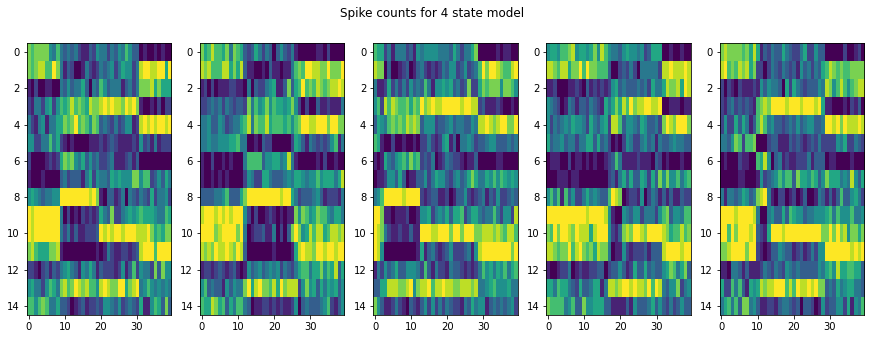

In [2]:
# Some poisson spiking
length = 400
bin_width = 10
states = 4
nrns = 15
tastes = 4
trials = 20
idx = np.arange(length)

#true_tau = np.cumsum(np.random.random((tastes,trials,states)),axis=-1)
true_tau = np.cumsum(np.random.uniform(2,30, size = (tastes,trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[...,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

state_inds = np.concatenate([np.zeros((tastes,trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)

true_lambda = np.random.random((tastes,nrns,states))

true_r = np.zeros((tastes,trials, nrns, length))

for taste in range(tastes):
    for trial_num in range(trials):
        for state_num in range(states):
            true_r[taste,trial_num,:,state_inds[taste,trial_num,state_num]:state_inds[taste,trial_num,state_num+1]] = \
                            true_lambda[taste,:,state_num][:,np.newaxis]
        
data_array = np.random.random(true_r.shape) < true_r   

# Spike array : tastes x trials x neurons x timebins
spike_array = np.sum(data_array.reshape((*data_array.shape[:3],-1,bin_width)),axis=-1)
spike_array_long = np.concatenate(spike_array, axis=0) 

## Visualize some trials
taste_ind = 0
trial_count = 5

imshow_kwargs = dict(interpolation = 'nearest', aspect = 'auto')
fig,ax = plt.subplots(1,trial_count, figsize = (15,5))
for plot_dat, this_ax in zip(spike_array[taste_ind][:trial_count], ax.flatten()):
    this_ax.imshow(plot_dat, **imshow_kwargs)
plt.suptitle(f'Spike counts for {states} state model');

In [3]:
################
# Generate shuffled data
# Spike array : tastes x trials x neurons x timebins
inds = list(np.ndindex((data_array.shape[0], *data_array.shape[2:])))
shuffle_data = np.zeros(data_array.shape)

for this_ind in inds:
    shuffle_data[this_ind[0],:,this_ind[1], this_ind[2]] = np.random.permutation(data_array[this_ind[0],:,this_ind[1], this_ind[2]])
shuffle_spikes = np.sum(shuffle_data.reshape((*shuffle_data.shape[:3],-1,bin_width)),axis=-1)
shuffle_spikes = np.vectorize(np.int)(shuffle_spikes)    

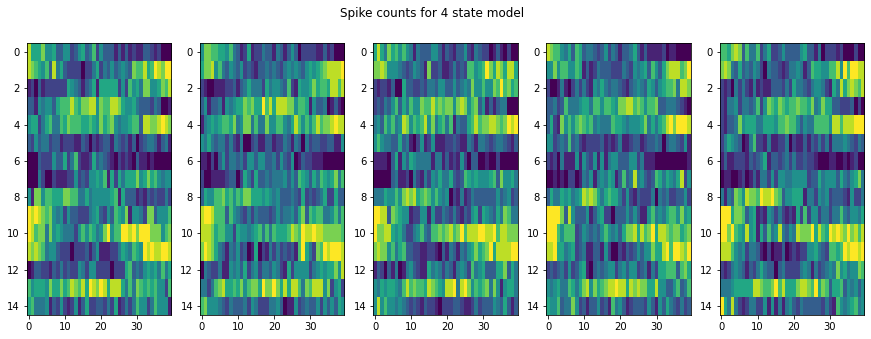

In [4]:
## Visualize some trials
taste_ind = 0
trial_count = 5

imshow_kwargs = dict(interpolation = 'nearest', aspect = 'auto')
fig,ax = plt.subplots(1,trial_count, figsize = (15,5))
for plot_dat, this_ax in zip(shuffle_spikes[taste_ind][:trial_count], ax.flatten()):
    this_ax.imshow(plot_dat, **imshow_kwargs)
plt.suptitle(f'Spike counts for {states} state model');

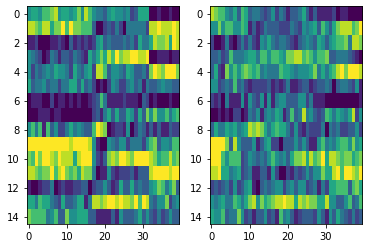

In [5]:
# Single neuron plots
fig,ax = plt.subplots(1,2)
taste_ind = 0
trial_ind = 3
img_kwargs = dict(aspect='auto', interpolation='nearest')
ax[0].imshow(spike_array[taste_ind,trial_ind], **img_kwargs)
ax[1].imshow(shuffle_spikes[taste_ind,trial_ind], **img_kwargs)

In [6]:
data_list = [spike_array[taste_ind,trial_ind], shuffle_spikes[taste_ind,trial_ind]]

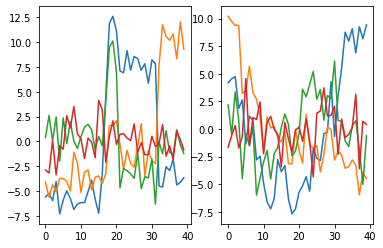

In [7]:
pca_list = [PCA(n_components = 4).fit_transform(x.T).T for x in data_list]
fig,ax = plt.subplots(1,2)
taste_ind = 0
trial_ind = 3
img_kwargs = dict(aspect='auto', interpolation='nearest')
ax[0].plot(pca_list[0].T)
ax[1].plot(pca_list[1].T)

In [8]:
pca_list[1].shape

(4, 40)

In [9]:
n_components = pca_list[0].shape[0]
x = np.arange(data_list[0].shape[1])
with pm.Model() as model:
    l = pm.Gamma("l", alpha=5, beta=1, testval = 0.5)
    eta = pm.Gamma("eta", alpha=0.7, beta=2)#pm.HalfCauchy("η", beta=0.1)
    # Specify the covariance function.
    #http://evelinag.com/Ariadne/covarianceFunctions.html
    cov = eta * pm.gp.cov.ExpQuad(1, ls=l)
    gp = pm.gp.Latent(cov_func=cov)
    
    factors = pm.Deterministic('factors',
                    tt.stack([
                        gp.prior(f"f{i}", X=x[:, None],testval = pca_list[1][i]) \
        for i in range(n_components)])
                                    )
    
    proj_mat = pm.Normal('proj_mat', mu = 0, sigma = 0.3, shape = (nrns, n_components))
    lambda_latent = pm.Deterministic('lambda_latent', tt.dot(proj_mat, factors))
    lambda_ = pm.Deterministic('lambda_', np.exp(lambda_latent))
    prior_checks = pm.sample_prior_predictive(samples=50)
print(prior_checks['lambda_'].shape)
print(prior_checks['proj_mat'].shape)

(50, 15, 40)
(50, 15, 4)


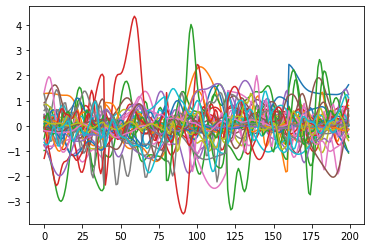

In [10]:
plt.plot(prior_checks['factors'].reshape((40,-1)).T);

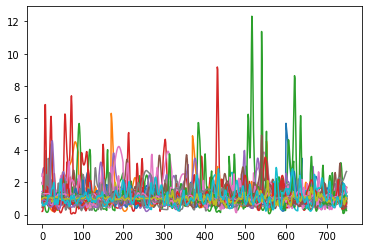

In [11]:
plt.plot(prior_checks['lambda_'].reshape((40,-1)).T);

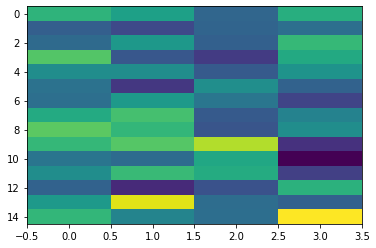

In [12]:
plt.imshow(prior_checks['proj_mat'].mean(axis=0), **img_kwargs, cmap = 'viridis')

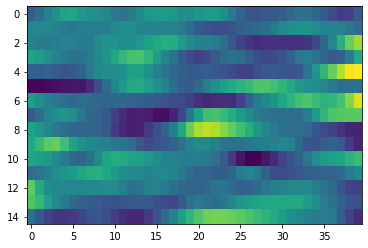

In [13]:
plt.imshow(stats.zscore(prior_checks['lambda_'], axis=-1).mean(axis=0), **img_kwargs)

In [14]:
n_components = pca_list[0].shape[0]
x = np.arange(data_list[0].shape[1])
with pm.Model() as model:
    data = pm.Data('data', data_list[0])
    
    #     hyper_step = pm.Exponential("hyper_step", 0.05)
    #     step_size = pm.Exponential("step_size", hyper_step, shape = trials)
    #     factors = pm.Deterministic('factors',
    #                                tt.stack([pm.GaussianRandomWalk(f"factor{i}", sigma=step_size[i], 
    #                             shape=length//bin_width, testval = pca_list[1][i]) for i in range(n_components)]))
    
    l = pm.Gamma("l", alpha=5, beta=1, testval = 0.5)
    eta = pm.Gamma("eta", alpha=0.7, beta=2)#pm.HalfCauchy("η", beta=0.1)
    # Specify the covariance function.
    #http://evelinag.com/Ariadne/covarianceFunctions.html
    cov = eta * pm.gp.cov.ExpQuad(1, ls=l)
    gp = pm.gp.Latent(cov_func=cov)
    
    factors = pm.Deterministic('factors',
                    tt.stack([
                        gp.prior(f"f{i}", X=x[:, None],testval = pca_list[1][i]) \
        for i in range(n_components)])
                                    )
    
    proj_mat = pm.Normal('proj_mat', mu = 0, sigma = 0.3, shape = (nrns, n_components))
    lambda_latent = pm.Deterministic('lambda_latent', tt.dot(proj_mat, factors))
    lambda_ = pm.Deterministic('lambda_', np.exp(lambda_latent))
    rate = pm.Poisson("rate", lambda_, observed=data)

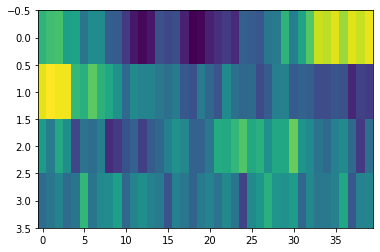

In [15]:
plt.imshow(model.factors.tag.test_value, **img_kwargs)

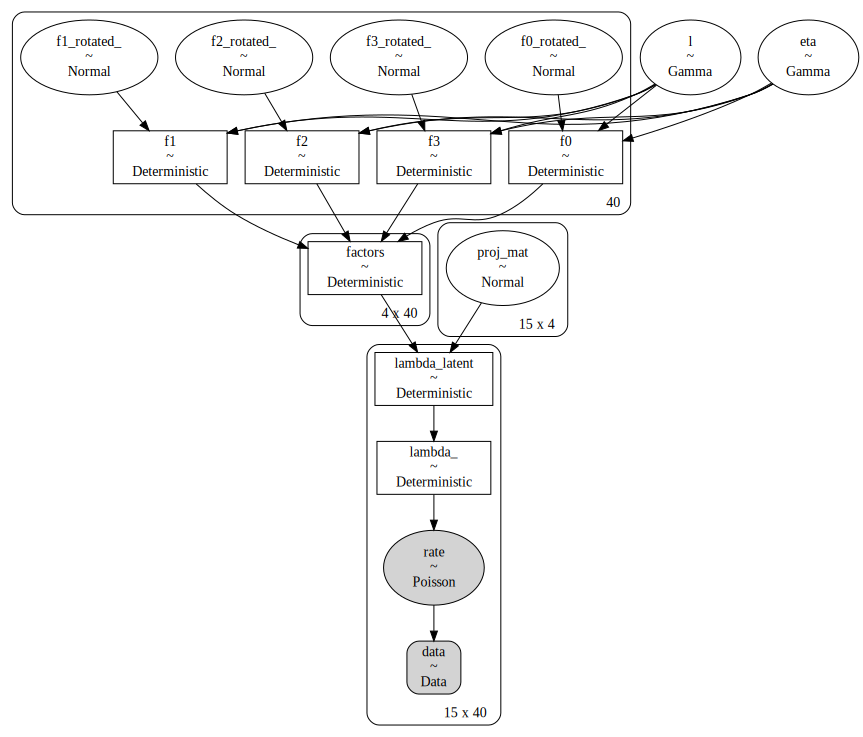

In [16]:
pm.model_to_graphviz(model)

In [17]:
trace_list = []
for this_data in data_list:
    with model:
        pm.set_data({'data': this_data})
        #trace = pm.sample(1000, chains=1, cores=1)
        #trace_list.append(trace[::10])
    
        inference = pm.ADVI('full-rank')
        approx = pm.fit(n=160000, method=inference)
        trace = approx.sample(draws=2000)
        trace_list.append(trace)

Finished [100%]: Average Loss = 1,419.4


Finished [100%]: Average Loss = 1,364.8


In [30]:
# with model:
#     pm.traceplot(trace_list[0])

In [28]:
import arviz as az
with model:
    df_comp_loo = az.compare({"sharp": trace_list[0], "smooth": trace_list[1]})
df_comp_loo

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
smooth,0,-1285.094945,116.711561,0.000000,0.992703,17.425763,0.000000,True,log
sharp,1,-1657.975248,324.521264,372.880303,0.007297,38.770595,36.196439,True,log


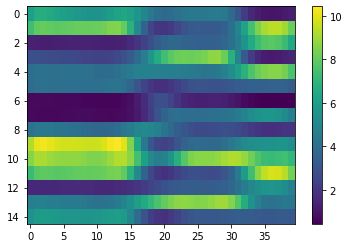

In [19]:
#plt.imshow(np.stack([trace_list[0][f'volatility{i}'].mean(axis=0) for i in range(trials)]), **img_kwargs)
plt.imshow(trace_list[0]['lambda_'].mean(axis=0), **img_kwargs)
plt.colorbar()

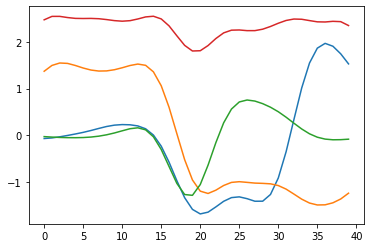

In [20]:
plt.plot(trace_list[0]['factors'].mean(axis=0).T);

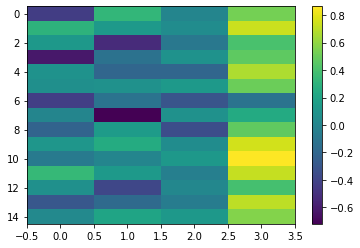

In [21]:
plt.imshow(trace_list[0]['proj_mat'].mean(axis=0), **img_kwargs)
plt.colorbar()

In [22]:
ppc_list = [pm.sample_posterior_predictive(x, samples = 2000, model = model, var_names = ['lambda_']) for x in trace_list]

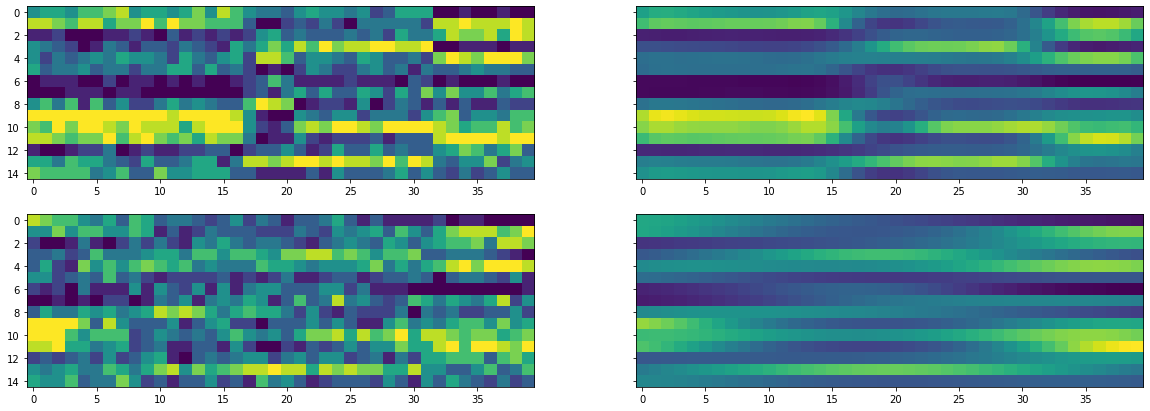

In [23]:
fig, ax = plt.subplots(2,2, figsize = (20,7), sharey = True)
ax[0,0].imshow(data_list[0], **img_kwargs)
ax[0,1].imshow(np.mean(ppc_list[0]['lambda_'],axis=0), **img_kwargs);

#==========================================================
ax[1,0].imshow(data_list[1], **img_kwargs)
ax[1,1].imshow(np.mean(ppc_list[1]['lambda_'],axis=0), **img_kwargs);

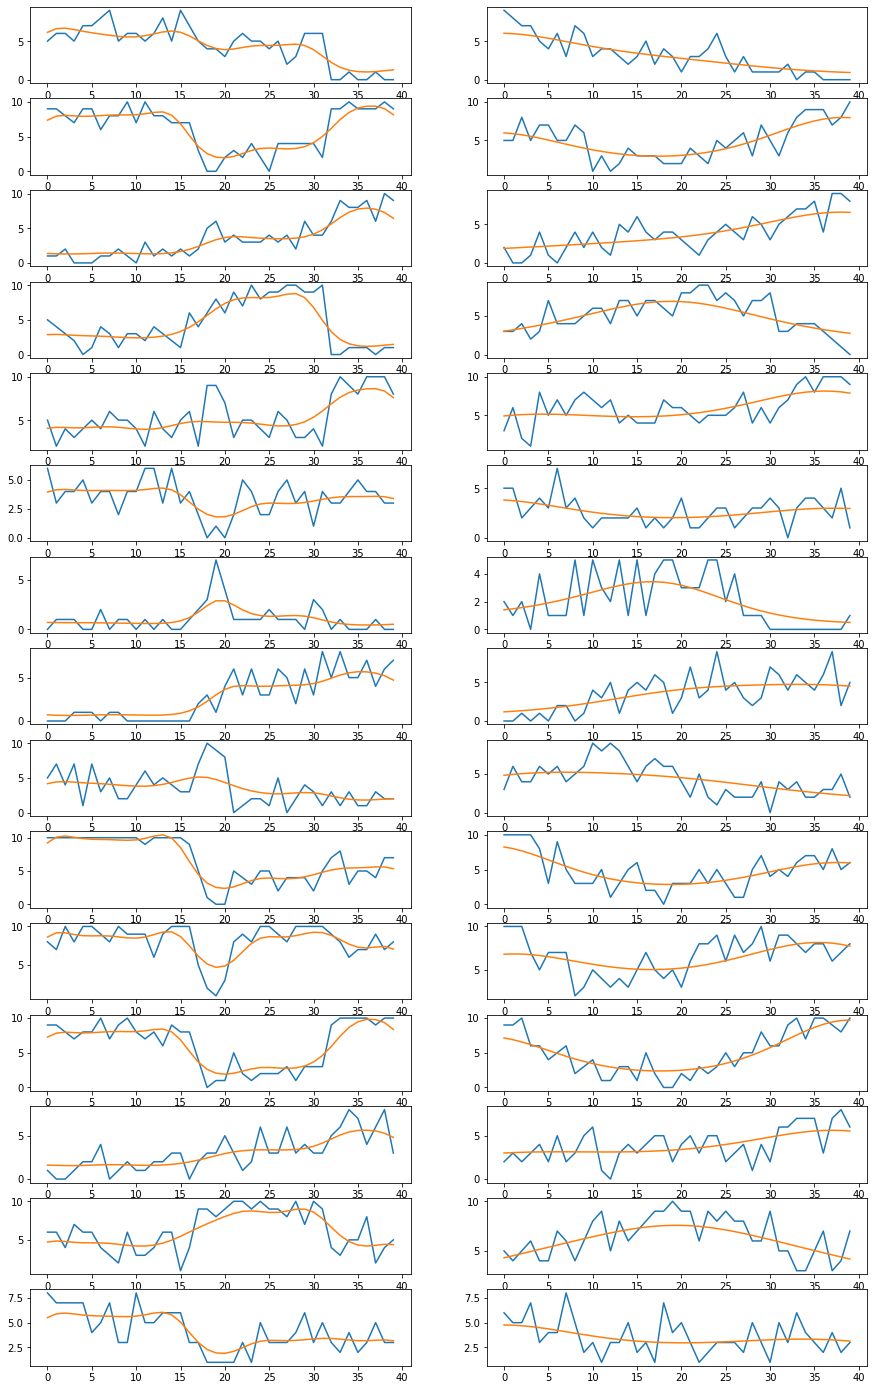

In [24]:
fig,ax = plt.subplots(nrns,2, figsize = (15,25))
for num, this_ax in enumerate(ax):
    this_ax[0].plot(data_list[0][num])
    this_ax[0].plot(np.mean(ppc_list[0]['lambda_'],axis=0)[num])
    this_ax[1].plot(data_list[1][num])
    this_ax[1].plot(np.mean(ppc_list[1]['lambda_'],axis=0)[num])

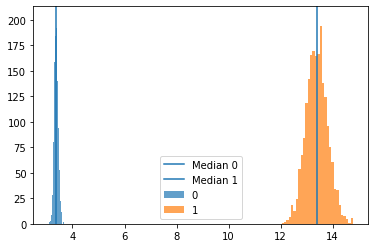

In [25]:
for num, this_trace in enumerate(trace_list):
    plt.hist(this_trace['l'], alpha = 0.7, label = str(num), bins = 30)
    plt.axvline(np.median(this_trace['l']), label = f'Median {num}')
plt.legend()

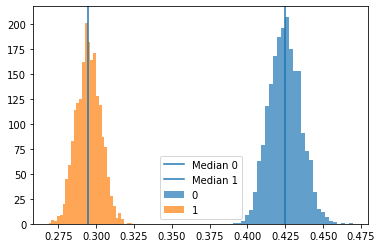

In [26]:
for num, this_trace in enumerate(trace_list):
    plt.hist(this_trace['eta'], alpha = 0.7, label = str(num), bins = 30)
    plt.axvline(np.median(this_trace['eta']), label = f'Median {num}')
plt.legend()